In [80]:
from Bio import SeqIO

In [2]:
### First we handle our files ###
tree_infile = f"../000_000_341.tree"
alignment_infile = f"../000_000_341.fas.alg"
table_infile = f"../000_000_341.tsv"
uniprot_infile = f"../uniprot_2018_09.json"

### And we store them in different variables ###
try:
    with open(table_infile, "r") as table_file:
        table_info = table_file.readlines()
except:
    print ("No table infile.")
        
try:
    with open(alignment_infile, "r") as alignment_file:
        alignment_info = alignment_file.read()
except:     
    print ("No alignment infile.")
        
import json
uniprot_info = {}
with open(uniprot_infile, "r") as uniprot_file:
    for line in uniprot_file:
        uniprot_entry = json.loads(line)
        uniprot_info.update(uniprot_entry)

In [ ]:
print (uniprot_info)

In [3]:
### LOADING THE SPECIFIED TAG INFORMATION FROM OUR ALIGNMENT ###
def retrieve_features (feature_tag, table_file):
    uniprot_hit_hash = {}
    for line in table_file:
        hit_type = line.split("\t")[2]
        hit_name = line.split("\t")[1]
        if (hit_type == ("swissprot_best" or "swissprot_exact") and hit_name not in uniprot_hit_hash):
            features_newlist = []
            for feature in uniprot_info[hit_name]["FT"]:
                if feature["ft"] == feature_tag:
                    features_newlist.append(feature)
            if len(features_newlist) > 0:
                uniprot_hit_hash[hit_name] = features_newlist
    return uniprot_hit_hash

In [72]:
uniprot_hit_hash = retrieve_features("HELIX", table_info)
print (uniprot_hit_hash)

{'Q9BQ69': [{'ft': 'HELIX', 's': '94', 'e': '94', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '107', 'e': '107', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '111', 'e': '111', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '122', 'e': '122', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '128', 'e': '128', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '148', 'e': '148', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '161', 'e': '161', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '182', 'e': '182', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '193', 'e': '193', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '237', 'e': '237', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '276', 'e': '276', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '295', 'e': '295', 'ann': '{ECO:0000244|PDB:2X47}.'}, {'ft': 'HELIX', 's': '308', 'e': '308', 'ann': '{ECO:0000244|PDB:2X47}.'}], 'O67077': [{'f

In [170]:
def get_alignment_position (sequence_position, sequence):
    alignment_position = 0
    for aminoacid in sequence:
        
    # EL PROBLEMA QUE TENGO CON EL CODIGO QUE ESTA AQUI ABAJO
    # ES QUE SI LE PONGO POSICION 0, EN VEZ DE COGER LA PRIMERA
    # LETRA, COGE EL PRIMER GUION DE TODO
    
    
    
#     alignment_position = 0
#     position_controller = 0
#     for aminoacid in sequence:
#         if position_controller < sequence_position:
#             if aminoacid != "-":
#                 position_controller +=1
#         else:
#             print (aminoacid)
#             break
        
#         if position_controller < sequence_position:
#             if aminoacid != "-":
#                 position_controller += 1
#         else:  
#             break
#         alignment_position += 1
#     print (alignment_position)
#     print (sequence[alignment_position])
    return alignment_position
sequence = "-MSLQSRLSGRLAQLRAAGQLLVPPRPRPGHLAGATRTRSSTCGPPAFLGVFGRRARTSAGVGAWGAAAVGRTAGVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEHYFCKDFVRLKKIPTWKEM--------AKGVAVKVEEPRYKKDKQLNEKISLLRSDITKLEVDAIV---------------NAA----------------NSSLL-----------------------------------------------GGGGVDGCIHR--------------------AAGPLLTDECRTLQS--------------------------------------------------------CKTGKAKITGGYRLPAKY------------VIHTVGPIAYGEPSASQAAELRS--------------------------------------------------------CYLSSLDLLLEHRLRSV--AFPCISTGVFGYPCEAAAEIVLATLRE--WLEQHKDKVDRLII-----------------------------------------------------------------------------------CVF---------------------------------------------------------------LEKDEDI--------------YRSRLPHYFPV------------------------------------------------------A------------------------------------------------------------------------------------------------------------------------------MNALKNFFIWAIIIGAAIVAFNL--------------FEGKREFTTKVSLNEVVKLVEEGKVSYAEVRGNTAIIQTKDGQKLEVTLPPNTNLVDKMVEKGVRVEVANPEPPGGWLVNVFLSWLPILFFIGIWIFLLRQMSGGGNVNRAFNFGKSRAKVYIEEKPKVTFKDVAGIEEVKEEVKEIIEYLKDPVKFQKLGGRPPKGVLLYGEPGVGKTLLAKAIAGEAHVPFISVSGSDFVEMFVGVGAARVRDLFETAKKHAPCIIFIDEIDAVGRARGAIPVGG-GHDEREQTLNQLLVEMDGFDTSDGIIVIAATNRPDILDPALLRPGRFDRQIFIPKPDVRGRYEILKVHARNKKLAKDVDLEFVARATPGFTGADLENLLNEAALLAARKGKEEITMEEIEEALDRITMGLERKGMTISPKEKEKIAIHEAGHALMGLVSDDDDKVHKISIIPRGMALGVTQQLPIEDKHIYDKKDLYNKILVLLGGRAAEEVFFGKDGITTGAENDLQRATDLAYRMVSMWGMSDKVGPIAIRRVANPFLGGMTTAVDTSPDLLREIDEEVKRIITEQYEKAKAIVEEYKEPLKAVVKKLLEKETITCEEFVEVFKLYGIELKDKCKKEELFDKDRKSEENKELKSEEVKEEVV"
position = get_alignment_position (0, sequence)

(
[
-
@
/
M
S
L
Q
S
R
L
S
G
R
L
A
Q
L
R
A
A
G
Q
L
L
V
P
P
R
P
R
P
G
H
L
A
G
A
T
R
T
R
S
S
T
C
G
P
P
A
F
L
G
V
F
G
R
R
A
R
T
S
A
G
V
G
A
W
G
A
A
A
V
G
R
T
A
G
V
R
T
W
A
P
L
A
M
A
A
K
V
D
L
S
T
S
T
D
W
K
E
A
K
S
F
L
K
G
L
S
D
K
Q
R
E
E
H
Y
F
C
K
D
F
V
R
L
K
K
I
P
T
W
K
E
M
-
-
-
-
-
-
-
-
A
K
G
V
A
V
K
V
E
E
P
R
Y
K
K
D
K
Q
L
N
E
K
I
S
L
L
R
S
D
I
T
K
L
E
V
D
A
I
V
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
N
A
A
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
N
S
S
L
L
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
G
G
G
G
V
D
G
C
I
H
R
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
A
A
G
P
L
L
T
D
E
C
R
T
L
Q
S
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
C
K
T
G
K
A
K
I
T
G
G
Y
R
L
P
A
K
Y
-
-
-
-
-
-
-
-
-
-
-
-
V
I
H
T
V
G
P
I
A
Y
G
E
P
S
A
S
Q
A
A
E
L
R
S
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
C
Y
L
S
S
L
D
L
L
L
E
H
R
L
R
S
V
-
-
A


NameError: name 'alignment_position' is not defined

In [100]:
def get_positions_matrix (feature_hash, alignment_file):
    from Bio import SeqIO
    record_dict = SeqIO.index(alignment_file, "fasta")
    position_matrix = []
    for unigene in feature_hash:
        unigene_sequence = record_dict[unigene].seq
        for feature in feature_hash[unigene]:
            feature_start = int(feature["s"])
            feature_end = int(feature["e"])
# TO FINISH           alignment_feature_start = get_alignment_position(feature_start, unigene_sequence)
# TO FINISH           alignment_feature_end = get_alignment_position(feature_end, unigene_sequence)
            for position in range (feature_start, feature_end+1):
                position_matrix.append(position)
    position_matrix = list(set(position_matrix))
    position_matrix.sort()
    return position_matrix

position_matrix = get_positions_matrix(uniprot_hit_hash, alignment_infile)
# SET VS LIST https://stackoverflow.com/questions/2831212/python-sets-vs-lists

--MSLQSRLSGRLAQLRAAGQLLVPPRPRPGHLAGATRTRSSTCGPPAFLGVFGRRARTSAGVGAWGAAAVGRTAGVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEHYFCKDFVRLKKIPTWKEM--------AKGVAVKVEEPRYKKDKQLNEKISLLRSDITKLEVDAIV---------------NAA----------------NSSLL-----------------------------------------------GGGGVDGCIHR--------------------AAGPLLTDECRTLQS--------------------------------------------------------CKTGKAKITGGYRLPAKY------------VIHTVGPIAYGEPSASQAAELRS--------------------------------------------------------CYLSSLDLLLEHRLRSV--AFPCISTGVFGYPCEAAAEIVLATLRE--WLEQHKDKVDRLII-----------------------------------------------------------------------------------CVF---------------------------------------------------------------LEKDEDI--------------YRSRLPHYFPV------------------------------------------------------A
------------------------------------------------------------------------------------------------------------------------------MNALKNFFIWAIIIGAAIVAFNL--------------FEGKREFTTKVSLNEVVKLVEEGKVSYAEVRGNTAIIQTKDGQKLEVTLPPNTNLVDKMVE

In [58]:
position_matrix = get_positions_matrix(uniprot_hit_hash, alignment_file)
# print (position_matrix)

Q9BQ69
O67077


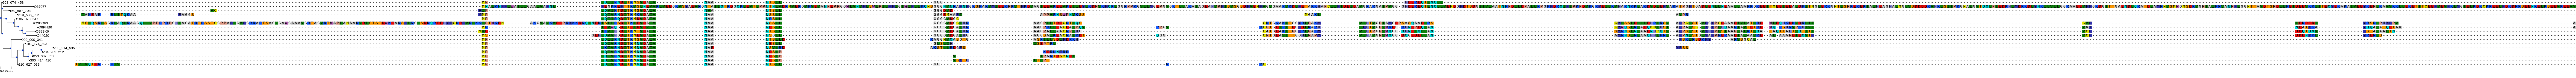

In [23]:
### LOADING THE TREE WITH ETE3 AND PAINTING THE ACT SITES ###    
from ete3 import PhyloTree, TreeStyle
tree = PhyloTree(tree_infile, alignment=alignment_info, alg_format="fasta")
tree.show()
tree.render('%%inline')